In [1]:
import xarray as xr
import cf_xarray

As Shaun suggested, this action attempts to load the entire data set into memory at once.

```
from erddapy import ERDDAP 
e = ERDDAP(server="https://data.pmel.noaa.gov/pmel/erddap", protocol="griddap")
e.dataset_id = "argo_temp_rfrom"
e.griddap_initialize()
data = e.to_xarray() # this is often the part that crashes
```

The following code, will load the metadata and dimensions, but not the data until you take some action to load the data.a

In [3]:
data = xr.open_dataset("https://data.pmel.noaa.gov/pmel/erddap/griddap/argo_temp_rfrom", chunks={'pressure': 1, 'time': 1})
data

<xarray.Dataset>
Dimensions:            (time: 1566, pressure: 58, latitude: 720, longitude: 1440)
Coordinates:
  * time               (time) datetime64[ns] 1993-01-01 ... 2022-12-30
  * pressure           (pressure) float32 2.5 10.0 20.0 ... 1.9e+03 1.975e+03
  * latitude           (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude          (longitude) float32 0.125 0.375 0.625 ... 359.6 359.9
Data variables:
    ocean_temperature  (time, pressure, latitude, longitude) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/31)
    cdm_data_type:              Grid
    Conventions:                CF-1.8, COARDS, ACDD-1.3
    creator_email:              pmel.info@noaa.gov
    creator_name:               NOAA PMEL, CIMAR
    creator_type:               institution
    creator_url:                https://www.pmel.noaa.gov/
    ...                         ...
    standard_name_vocabulary:   CF Standard Name Table v70
    summary:                    TEMP RFROM with seasonal cycle. NOAA Pacific ...
    time_coverage_end:          2022-12-30T00:00:00Z
    time_coverage_start:        1993-01-01T00:00:00Z
    title:                      Argo TEMP RFROM
    Westernmost_Easting:        0.125

For this example we'll only consider the near surface data (pressure==2.5). If you were working with volumes of data then you might rethink the chunk size for the pressure dimension.

In [6]:
surface = data.ocean_temperature.sel({'pressure':2.5})
surface

<xarray.DataArray 'ocean_temperature' (time: 1566, latitude: 720,
                                       longitude: 1440)>
dask.array<getitem, shape=(1566, 720, 1440), dtype=float32, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-08 ... 2022-12-30
    pressure   float32 2.5
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Attributes:
    colorBarMaximum:  10.0
    colorBarMinimum:  -10.0
    Description:      mapped ocean conservative (TEOS-10) averaged from upper...
    long_name:        Ocean Temperature
    units:            degree_Celsius

From the surface, we'll take an unweighted mean just to illustrate how the data access works with the chunks and lazy loading.
Nothing happens execpt that xarray know that the result of this computation will be an array of 1556 elements.

In [7]:
m = surface.mean(('latitude','longitude'))
m

<xarray.DataArray 'ocean_temperature' (time: 1566)>
dask.array<mean_agg-aggregate, shape=(1566,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1993-01-01 1993-01-08 ... 2022-12-30
    pressure  float32 2.5

When we ask for the plot, then the code will start asking for data from the server, but since we chunked it, it will get one time step at a time.
For illustration purposes, we'll plot the first 100 time steps.
On our server it took about 2 minutes on our development server.

CPU times: user 10 s, sys: 2.54 s, total: 12.5 s
Wall time: 2min 12s


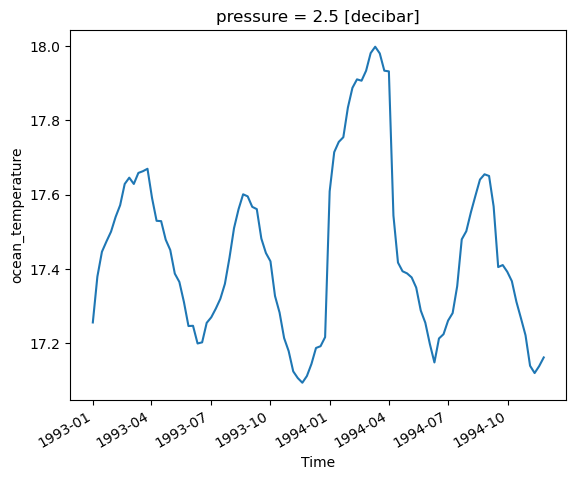

In [10]:
%%time
m[0:100].plot()